# Reducción de dimensionalidad con PCA

*Principal Component Analysis* (PCA) es un método clásico que permite proyectar nuestros datos y reducir su dimensionalidad. Primero se revisa el método de forma teórica y luego su implementación en la librería `sklearn`.

## Formalismo matemático

PCA es un procedimiento estadístico que busca una **transformación ortogonal** que **maximice la varianza** de los datos. 

Matemáticamente, podemos escribir un conjunto de datos $\{x_i\}$ con $i=1,2,\ldots, N$ y $x_i \in \mathbb{R}^D$, como una matriz $X \in \mathbb{R}^{N\times D}$. La transformación en PCA está representada por una matriz $W \in \mathbb{R}^{D\times D}$ y los datos transformados se obtienen mediante una multiplicación matricial

$$
\hat X = X W
$$

Una transformación es ortogonal si cumple $W^T W = I$ es decir que la transformación traspuesta es equivalente a su inversa. Para encontrar una transformación que maximice la varianza de los datos debemos obtener primero $C$ la matriz de covarianza de $X$. 

Asumiendo que las columnas de $X$ están centradas (su media es cero), la covarianza de $X$ se define como

$$
C = \frac{1}{N} X^T X
$$

donde $C \in \mathbb{R}^{D\times D}$. 

Luego, la matriz de covarianza de los datos transformados $\hat X$ es 

$$
\hat C = \frac{1}{N} \hat X^T \hat X = \frac{1}{N} (X W)^T X W = \frac{1}{N} W^T X^T X W = W^T C W
$$

Con lo anterior podemos escribir la siguiente función objetivo

$$
\max_W W^T C W \text{ sujeto a } W^T W = I
$$

Utilizando *multiplicadores de Lagrange* para incluir la restricción en el objetivo y derivando e igualando a cero se obtiene lo siguiente

$$
\begin{align}
\frac{d}{dW} W^T C W + \Lambda(I- W^T W) &= 0 \nonumber \\ 
(C - \Lambda) W &= 0 \nonumber
\end{align}
$$

donde $\Lambda = \lambda I$ y $\lambda = (\lambda_1, \lambda_2, \ldots, \lambda_D)$.

:::{important}

Este problema de optimización corresponde al problema de los valores y vectores propios ($\lambda$ y $W$) de la matriz $C$. 

:::

## Implementación utilizando `scipy`

A modo de ejemplo sean los siguientes datos bidimensionales

In [1]:
import numpy as np

X = np.random.multivariate_normal([0, 0], [[0.5, -0.7], [-0.7, 1]], size=1000)

Utilicemos PCA para encontrar los ejes coordenados de máxima varianza y graficarlos. Para resolver el problema de valores propios podemos utilizar `scipy.linalg.eigh`:

In [2]:
import scipy.linalg

# Restamos la media
X_ = X - np.mean(X, axis=0, keepdims=True)
# Calculamos la covarianza
C = np.dot(X_.T, X_)/len(X_)
# Calculamos los valores y vectores propios de la covarianza
L, W = scipy.linalg.eigh(C)
# Proyectamos
U = np.dot(X, W)

El resultado gráfico es:

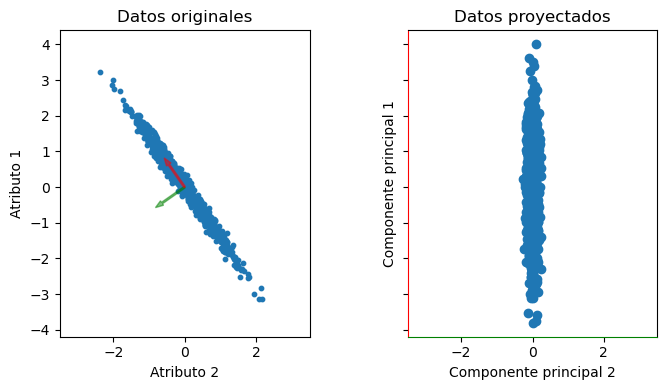

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

arrow_args = {'width': 0.05, 'length_includes_head': True, 'alpha': 0.5}
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, 
                       sharex=True, sharey=True)
ax[0].scatter(X[:, 0], X[:, 1], s=10);
for i, c in enumerate(['g', 'r']):
    ax[0].arrow(0, 0, W[i, 0], W[i, 1], color=c, **arrow_args)

ax[0].set_aspect('equal'); 
ax[1].set_aspect('equal');
ax[0].set_xlim([-3.5, 3.5])
ax[1].scatter(U[:, 0], U[:, 1])
ax[1].spines['bottom'].set_color('g')
ax[0].set_ylabel('Atributo 1')
ax[0].set_xlabel('Atributo 2')
ax[1].set_ylabel('Componente principal 1')
ax[1].set_xlabel('Componente principal 2')
ax[1].spines['left'].set_color('r')
ax[0].set_title('Datos originales')
ax[1].set_title('Datos proyectados');

:::{note}

- El eje rojo acumula un 99.5% de la varianza
- El eje verde es ortogonal al rojo
- Los nuevos ejes están decorrelacionados c/r a los originales

:::

## Reducción de dimensionalidad 

Una aplicación típica de PCA es la reducción de dimensionalidad. Recordemos:

- La matriz $W$ tiene las mismas dimensiones que $C$
- Las columnas de $W$ son los vector propios
- Cada vector propio tiene un valor propio asociado

:::{note}

El valor propio $\lambda_i$ asociado a la columna $i$ de $W$ corresponde a la "cantidad de varianza" de dicha columna.

:::

Para obtener una proyección que disminuya la dimensionalidad necesitamos una matriz

$$
\widehat W \in \mathbb{R}^{D\times \hat D}
$$

con $\hat D < D$. Podemos obtener $\widehat W$ uniendo un subconjunto de las columnas de $W$. En particular nos interesa proyectar a los vectores propios de mayor varianza. 

El valor de $\hat D$ se escoge de acuerdo a la aplicación:

- Para tareas de visualización de datos: $\hat D = 2$ o $3$
- Para tareas más generales de reducción de dimensionalidad o decorrelación de atributos, un criterio típico es seleccionar $\hat D$ tal que la suma de varianza acumulada sea al menos un 95%

:::{important}

Si proyectamos con $\widehat W$ la transformación no es invertible porque estamos "descartando" información. Es una compresión de tipo *lossy* (con pérdida).

:::

## Implementación de PCA en `sklearn`

PCA está incluido en el módulo [`sklearn.decomposition`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition). El constructor y sus argumentos más importantes son:

```python
PCA(n_components=None, # Cantidad (int) o porcentaje de varianza (float) a retener
    copy=True, # Si es falso, la data transformada reemplaza la original
    whiten=False, # Reescala los datos para que tengan igual dispersión
    ...
)
```

Los métodos más importantes de la clase `PCA` son:

- `fit(X)`: Calcula la matriz de covarianza y los vectores y valores propios
- `transform(X)`: Retorna la proyección de $X$
- `fit_transform(X)`: `fit` y `transform` en un solo paso
- `inverse_transform(hatX)`: Retorna los datos al espacio original (con pérdidas si $\hat D < D$)
- `get_covariance()`: Retorna la matriz de covarianza

Los atributos más importantes son:

- `components_`: Los componentes principales (vectores propios)
- `singular_values_`: Los valores propios
- `explained_variance_ratio_`: El porcentaje de varianza asociado a cada vector propio 



**Ejemplo** 

Sea la siguiente base de datos con **cuatro atributos numéricos** asociados a las características de un conjunto de 150 flores del género Iris separadas en 3 clases.

<img src="https://www.math.umd.edu/~petersd/666/html/iris_with_labels.jpg" width="200">

A continuación se presenta un gráfico de dispersión para visualizar las relaciones entre los atributos

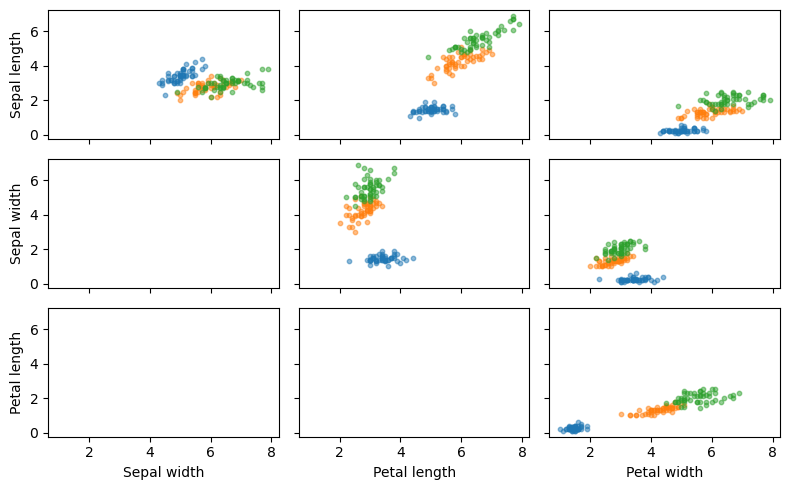

In [4]:
from sklearn.datasets import load_iris

iris_set = load_iris()
X, y, y_names = iris_set['data'], iris_set['target'], iris_set['target_names']

fig, ax = plt.subplots(3, 3, figsize=(8, 5), tight_layout=True, sharex=True, sharey=True)
for i in range(3):
    for j in range(i, 3):
        for y_ in range(3):
            ax[i, j].scatter(X[y==y_, i], X[y==y_, j+1], s=10, alpha=0.5)            

ax[0 ,0].set_ylabel('Sepal length')
ax[1 ,0].set_ylabel('Sepal width')
ax[2 ,0].set_ylabel('Petal length')
ax[2 ,0].set_xlabel('Sepal width')
ax[2 ,1].set_xlabel('Petal length')
ax[2 ,2].set_xlabel('Petal width');

Para hacer una visualización más concisa podemos usar PCA para reducir la dimensión de los datos de 4 a 2

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
hatX = pca.fit_transform(X)

Los valores propios:

In [6]:
pca.singular_values_

array([25.09996044,  6.01314738])

El porcentaje de varianza de cada valor propio:

In [7]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

Y finalmente los vectores propios:

In [8]:
hatW = pca.components_
hatW

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

Podemos estudiar la contribución de cada atributo a los nuevos ejes:

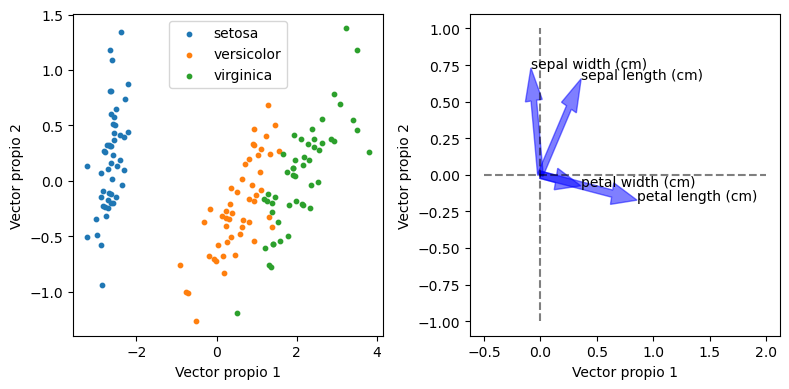

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
for y_, name in enumerate(y_names):
    ax[0].scatter(hatX[y==y_, 0], hatX[y==y_, 1], s=10, label=name)
ax[0].legend();
for ax_ in ax:
    ax_.set_ylabel('Vector propio 2'); ax_.set_xlabel('Vector propio 1')
ax[1].plot([0, 0], [-1 ,1], 'k--', alpha=0.5)
ax[1].plot([-0.5, 2], [0, 0],  'k--', alpha=0.5)
for i, name in enumerate(iris_set.feature_names):
    ax[1].arrow(0, 0, hatW[0, i], hatW[1, i], color='b', **arrow_args)
    ax[1].text(hatW[0, i], hatW[1, i], name)

- La figura de la izquierda son los datos de iris proyectados en los componentes principales más importantes
- La figura de la derecha muestra la contribución de los atributos originales a cada uno de los vectores propios

:::{note}

El tipo de flor, es decir las clases de Iris, pueden separarse en el eje del vector propio 1. Podemos ver también que las variables que tienen que ver con el sépalo están alineadas con el vector propio 2 (ángulo menor), en cambio las variables que tienen que ver con el pétalo están alineadas con el vector propio 1. En resumen la clase de la flor tiene mayor relación con el pétalo que con el sépalo.

:::